Tutos utiles pour manipuler les différents modules de pyspark:
- https://sparkbyexamples.com/pyspark-tutorial/

In [1]:
print('Notebook - Kernel PySpark')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1632400200287_0007,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Notebook - Kernel PySpark

In [2]:
import boto3

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
bucket = 'p8-prevot'

prefix = 'data/Test/'

client = boto3.client('s3')
result = client.list_objects(Bucket=bucket, Prefix=prefix, Delimiter='/')

for o in result.get('CommonPrefixes'):
    print('sub folder : ', o.get('Prefix'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

sub folder :  data/Test/apple_red_2/
sub folder :  data/Test/carrot_1/
sub folder :  data/Test/zucchini_1/

# I. Importation des images (chemin, caractéristiques, données) dans un dataframe Spark

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit
from functools import reduce

def image_df(bucket='p8-prevot', prefix = 'data/Test/'):
    
    '''Permet de créer un dataframe spark contenant les images et leurs caractéristiques'''
    client = boto3.client('s3')
    result = client.list_objects(Bucket=bucket, Prefix=prefix, Delimiter='/')

    dataframes = []
    
    for o in result.get('CommonPrefixes'):
        
        folder = o.get('Prefix')
        sub_folder = folder.split('/')[2]
        data_path = 's3://{}/{}'.format(bucket, folder)
        images_df = ImageSchema.readImages(data_path, recursive=True).withColumn("label", lit(sub_folder))
        dataframes.append(images_df)
        
    df = reduce(lambda first, second: first.union(second), dataframes)# repartition dataframe 
    df = df.repartition(200)# split the data-frame
    
    return df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
df = image_df()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------+
|               image|      label|
+--------------------+-----------+
|[s3://p8-prevot/d...|   carrot_1|
|[s3://p8-prevot/d...|apple_red_2|
|[s3://p8-prevot/d...|   carrot_1|
|[s3://p8-prevot/d...|apple_red_2|
|[s3://p8-prevot/d...|apple_red_2|
+--------------------+-----------+
only showing top 5 rows

In [7]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: string (nullable = false)

In [8]:
first_row = df.first()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
data_row = first_row.asDict()['image']['data']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
import numpy as np
array_image = np.array(data_row).reshape(first_row.asDict()['image']['height'],
                           first_row.asDict()['image']['width'],
                           first_row.asDict()['image']['nChannels'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
array_image.shape

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(641, 179, 3)

# II. Extraction de features (Descripteurs des points d'intérêts avec ORB)

In [12]:
import cv2 as cv

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

On va spécifier qu'il doit y avoir maximum 30 points d'intérêt.

In [13]:
orb = cv.ORB_create(nfeatures=30)
kp, des = orb.detectAndCompute(array_image,None)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
des

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([[156,  70,  98, 137, 222,  57, 250, 216, 191,  85, 247, 151, 203,
        206, 185,  72, 127, 137, 239, 254, 186, 167, 111, 211, 150, 101,
        139, 204, 183, 255,  33, 212],
       [191, 104, 240, 229, 236,  27, 255, 210,  95, 166, 180, 142, 139,
         42, 215,  10, 255, 237,  31, 255, 233, 118, 228, 202, 190, 221,
        239, 180, 255, 253, 113, 209],
       [226,  41, 192, 157, 108,  11, 124, 101,  29, 170, 240,  10, 174,
         42,  84,  81, 238, 239, 127, 194, 120, 123, 193, 200, 182, 184,
        223, 184,  20, 168, 242, 137],
       [200, 165,  82, 222, 110, 152, 239, 119, 173,   0, 250,  26, 239,
        235, 156, 215, 106, 231, 110,  42, 112,  43, 162, 237, 180, 249,
        102,   8,  70, 138, 163, 168],
       [ 66, 165,  98, 191, 124, 168, 248, 103, 173,   1, 251, 138, 238,
        190,   4,  83, 110, 247, 127, 128, 144, 251, 195, 229, 190, 124,
        218, 202,  69,   2, 163, 139],
       [204, 150, 114, 154, 254, 249, 250, 216,  61,  81, 255, 178, 205,
  

Chaque point d'intérêt est décrit par un descripteurs 32 valeurs (liés à l'intensité du gradient dans chaque direction autour du point d'intérêt)

In [15]:
def orb_descriptors(img):
    
    height = img[1]
    width = img[2]
    nchannels = img[3]
    data = img[5]
    
    img_array = np.array(data).reshape(height, width, nchannels)
    
    orb = cv.ORB_create(nfeatures=30)
    kp, des = orb.detectAndCompute(img_array,None)
    
    des = des.tolist()
    
    return des

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
orb_descriptors(first_row.asDict()['image'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[156, 70, 98, 137, 222, 57, 250, 216, 191, 85, 247, 151, 203, 206, 185, 72, 127, 137, 239, 254, 186, 167, 111, 211, 150, 101, 139, 204, 183, 255, 33, 212], [191, 104, 240, 229, 236, 27, 255, 210, 95, 166, 180, 142, 139, 42, 215, 10, 255, 237, 31, 255, 233, 118, 228, 202, 190, 221, 239, 180, 255, 253, 113, 209], [226, 41, 192, 157, 108, 11, 124, 101, 29, 170, 240, 10, 174, 42, 84, 81, 238, 239, 127, 194, 120, 123, 193, 200, 182, 184, 223, 184, 20, 168, 242, 137], [200, 165, 82, 222, 110, 152, 239, 119, 173, 0, 250, 26, 239, 235, 156, 215, 106, 231, 110, 42, 112, 43, 162, 237, 180, 249, 102, 8, 70, 138, 163, 168], [66, 165, 98, 191, 124, 168, 248, 103, 173, 1, 251, 138, 238, 190, 4, 83, 110, 247, 127, 128, 144, 251, 195, 229, 190, 124, 218, 202, 69, 2, 163, 139], [204, 150, 114, 154, 254, 249, 250, 216, 61, 81, 255, 178, 205, 222, 168, 96, 126, 155, 254, 178, 182, 183, 111, 231, 150, 116, 138, 207, 167, 135, 165, 213], [214, 245, 86, 167, 172, 75, 126, 253, 189, 178, 179, 186, 207, 127,

In [17]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
orb_UDF = udf(lambda img: orb_descriptors(img), ArrayType(ArrayType(IntegerType())))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
orb_df = df.withColumn("descriptors ORB", orb_UDF("image"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
first = orb_df.first()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Il y a bien 26 descripteurs de 32 composantes chacun

In [21]:
len(first['descriptors ORB'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

16

In [22]:
orb_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: string (nullable = false)
 |-- descriptors ORB: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: integer (containsNull = true)

In [23]:
from pyspark.sql.functions import explode

exploded_df = orb_df.select(orb_df['image'],orb_df['label'],explode(orb_df['descriptors ORB']))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Ce DataFrame contient une ligne par descripteur, (au maximum 30 descripteurs par image)

In [24]:
exploded_df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

7614

In [25]:
exploded_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: string (nullable = false)
 |-- col: array (nullable = true)
 |    |-- element: integer (containsNull = true)

In [26]:
desc_column_df = exploded_df.select('col').withColumnRenamed("col","Descripteur")
desc_column_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Descripteur: array (nullable = true)
 |    |-- element: integer (containsNull = true)

In [27]:
desc_column_df.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------------------------------------------------------------------------------------------------------------------------------------------+
|Descripteur                                                                                                                                             |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
|[56, 93, 59, 254, 15, 196, 149, 103, 220, 70, 204, 2, 182, 252, 33, 96, 200, 179, 187, 1, 106, 171, 114, 171, 241, 231, 218, 27, 21, 88, 116, 250]      |
|[182, 253, 70, 159, 222, 139, 254, 234, 61, 34, 250, 50, 236, 250, 49, 65, 127, 255, 127, 227, 112, 191, 73, 239, 180, 182, 143, 130, 85, 120, 97, 139] |
|[182, 77, 86, 191, 252, 43, 190, 226, 61, 162, 250, 18, 236, 234, 33, 64, 255, 239, 127, 227, 96, 183, 201, 239, 180, 246, 207, 130, 85, 120, 241, 131] |
|[162, 189, 6, 157, 220, 139, 190, 238, 190, 42, 250, 162, 172, 238, 3

# III. Réduction dimensionnelle (ACP sur les points d'intérêts)

In [28]:
from pyspark.ml.feature import PCA

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

On spécifie au maximum 20 composantes pour les descripteurs réduits

Il faut convertir les listes de descripteurs en vecteurs

In [29]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

df_with_vectors = desc_column_df.select(desc_column_df["Descripteur"],
                                        list_to_vector_udf(desc_column_df["Descripteur"]).alias("vector"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
df_with_vectors.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Descripteur: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- vector: vector (nullable = true)

In [31]:
df_with_vectors.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|         Descripteur|              vector|
+--------------------+--------------------+
|[104, 40, 70, 153...|[104.0,40.0,70.0,...|
|[74, 153, 190, 15...|[74.0,153.0,190.0...|
|[66, 185, 54, 152...|[66.0,185.0,54.0,...|
|[32, 205, 90, 255...|[32.0,205.0,90.0,...|
|[153, 77, 71, 254...|[153.0,77.0,71.0,...|
|[130, 45, 142, 15...|[130.0,45.0,142.0...|
|[195, 160, 102, 1...|[195.0,160.0,102....|
|[176, 205, 31, 25...|[176.0,205.0,31.0...|
|[177, 77, 71, 222...|[177.0,77.0,71.0,...|
|[219, 77, 78, 254...|[219.0,77.0,78.0,...|
|[66, 185, 58, 136...|[66.0,185.0,58.0,...|
|[2, 138, 178, 153...|[2.0,138.0,178.0,...|
|[27, 75, 107, 254...|[27.0,75.0,107.0,...|
|[2, 138, 162, 153...|[2.0,138.0,162.0,...|
|[2, 138, 130, 153...|[2.0,138.0,130.0,...|
|[162, 28, 122, 73...|[162.0,28.0,122.0...|
|[2, 136, 134, 153...|[2.0,136.0,134.0,...|
|[131, 147, 99, 20...|[131.0,147.0,99.0...|
|[162, 144, 122, 8...|[162.0,144.0,122....|
|[2, 185, 42, 136,...|[2.0,185.0

In [32]:
pca = PCA(k=30, inputCol="vector", outputCol="Descripteur-ACP")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
model = pca.fit(df_with_vectors)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Variance cumulée

In [34]:
cumValues = model.explainedVariance.cumsum()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
cumValues

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([0.15537487, 0.28328573, 0.37812855, 0.45802155, 0.50960773,
       0.5507649 , 0.58824903, 0.62304234, 0.65240203, 0.67899894,
       0.70480248, 0.72794345, 0.74970692, 0.77006828, 0.7888926 ,
       0.80734804, 0.8247075 , 0.84095689, 0.85636538, 0.87132826,
       0.88531318, 0.89848159, 0.91101659, 0.9233914 , 0.93504097,
       0.94632057, 0.95669296, 0.96663647, 0.97592378, 0.98467208])

Le matplotlib inline ne reconnait les variables globales du notebook, je n'ai pas trouvé d'explication.
Il faut copier les valeurs pour les afficher.

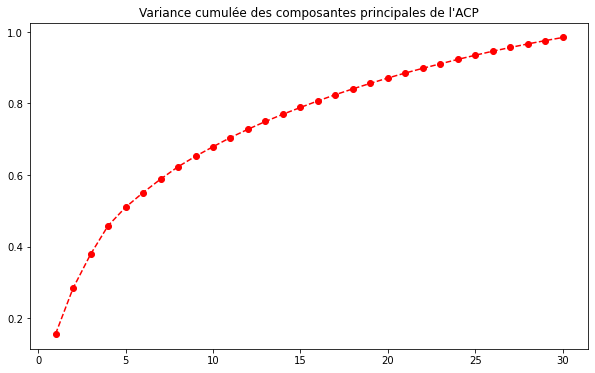

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

cumValues = [0.15537487, 0.28328573, 0.37812855, 0.45802155, 0.50960773,
       0.5507649 , 0.58824903, 0.62304234, 0.65240203, 0.67899894,
       0.70480248, 0.72794345, 0.74970692, 0.77006828, 0.7888926 ,
       0.80734804, 0.8247075 , 0.84095689, 0.85636538, 0.87132826,
       0.88531318, 0.89848159, 0.91101659, 0.9233914 , 0.93504097,
       0.94632057, 0.95669296, 0.96663647, 0.97592378, 0.98467208]

plt.figure(figsize=(10,6))
plt.title("Variance cumulée des composantes principales de l'ACP")
plt.plot(range(1,31), cumValues, color='r',
         marker = 'o', linestyle='--')

In [37]:
cumValues[19]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.8713282619951429

Plus de 87% de la variance est expliquée avec 20 variables.
Nous choisirons donc de réaliser une ACP de 20 composantes au maximum.

In [38]:
pca = PCA(k=20, inputCol="vector", outputCol="Descripteur-ACP")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
pca = pca.fit(df_with_vectors)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
pca.transform(df_with_vectors).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+
|         Descripteur|              vector|     Descripteur-ACP|
+--------------------+--------------------+--------------------+
|[104, 40, 70, 153...|[104.0,40.0,70.0,...|[150.514595103003...|
|[74, 153, 190, 15...|[74.0,153.0,190.0...|[428.855843838319...|
|[66, 185, 54, 152...|[66.0,185.0,54.0,...|[457.252577330120...|
|[32, 205, 90, 255...|[32.0,205.0,90.0,...|[324.767434922211...|
|[153, 77, 71, 254...|[153.0,77.0,71.0,...|[115.120956161282...|
|[130, 45, 142, 15...|[130.0,45.0,142.0...|[393.521863538775...|
|[195, 160, 102, 1...|[195.0,160.0,102....|[255.311557111819...|
|[176, 205, 31, 25...|[176.0,205.0,31.0...|[325.282576638731...|
|[177, 77, 71, 222...|[177.0,77.0,71.0,...|[142.236048508791...|
|[219, 77, 78, 254...|[219.0,77.0,78.0,...|[70.9466704788532...|
|[66, 185, 58, 136...|[66.0,185.0,58.0,...|[414.965991530804...|
|[2, 138, 178, 153...|[2.0,138.0,178.0,...|[430.796742827333...|
|[27, 75, 107, 254...|[27

Il doit être désormais possible de regrouper ces descripteur (décrits par 20 features chacun) en "visual word". 
En éxécutant un clustering Kmeans, il devient alors possible de regrouper les descripteurs qui se ressemblent le plus. Cela permettrait d'attribuer à chaque descripteur une unique valeur, correspondant au "visual word" correspondant.

Ainsi, chaque image serait décrite par une liste de "visual word" (de longeueur égale au nombre de descripteur détectés par ORB).
Il est ensuite possible de compter le nombre de visual word de chaque image (en faisant des opération de map reduce).
Pour la prédiction, on entraînerait un classifieur bayésien multimodal. Cela permettrait d'effectuer des prédiction sur le fruits en fonction du noombre de points d'intérêt détectés.

## Réduction dimensionnelle sur le spark dataframe de base:

In [41]:
exploded_df = orb_df.select(orb_df['image'],orb_df['label'],explode(orb_df['descriptors ORB']))
exploded_df = exploded_df.withColumnRenamed("col","Descripteur")
exploded_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: string (nullable = false)
 |-- Descripteur: array (nullable = true)
 |    |-- element: integer (containsNull = true)

In [42]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
exploded_df_2 = exploded_df.withColumn("Descripteur-vect", list_to_vector_udf(exploded_df["Descripteur"]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
exploded_df_2.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: string (nullable = false)
 |-- Descripteur: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Descripteur-vect: vector (nullable = true)

In [44]:
exploded_df_2 = exploded_df_2.drop('Descripteur')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
pca = PCA(k=20, inputCol="Descripteur-vect", outputCol="Descripteur-ACP")
pca = pca.fit(exploded_df_2)
exploded_df_2 = pca.transform(exploded_df_2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
exploded_df_2.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: string (nullable = false)
 |-- Descripteur-vect: vector (nullable = true)
 |-- Descripteur-ACP: vector (nullable = true)

In [47]:
exploded_df_2 = exploded_df_2.drop('Descripteur-vect')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
exploded_df_2.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- data: binary (nullable = false)
 |-- label: string (nullable = false)
 |-- Descripteur-ACP: vector (nullable = true)

# IV. Export au format parquet

Ce n'est plus une transformation mais une action

In [49]:
exploded_df_2.write.parquet(path="s3://p8-prevot/results/", mode="overwrite")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Ouverture du dataFrame SPark à partir du répertoire de résultats sur S3

In [50]:
df = sqlContext.read.parquet('s3://p8-prevot/results/')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------+--------------------+
|               image|   label|     Descripteur-ACP|
+--------------------+--------+--------------------+
|[s3://p8-prevot/d...|carrot_1|[343.772301477096...|
|[s3://p8-prevot/d...|carrot_1|[259.018964148121...|
|[s3://p8-prevot/d...|carrot_1|[391.243676222550...|
|[s3://p8-prevot/d...|carrot_1|[421.574994468874...|
|[s3://p8-prevot/d...|carrot_1|[398.804929967018...|
|[s3://p8-prevot/d...|carrot_1|[402.875472047792...|
|[s3://p8-prevot/d...|carrot_1|[349.853560961424...|
|[s3://p8-prevot/d...|carrot_1|[263.973792477903...|
|[s3://p8-prevot/d...|carrot_1|[367.125874619342...|
|[s3://p8-prevot/d...|carrot_1|[323.693884712273...|
|[s3://p8-prevot/d...|carrot_1|[436.733147148686...|
|[s3://p8-prevot/d...|carrot_1|[264.274258208548...|
|[s3://p8-prevot/d...|carrot_1|[393.643823711775...|
|[s3://p8-prevot/d...|carrot_1|[233.418603210058...|
|[s3://p8-prevot/d...|carrot_1|[277.213143465099...|
|[s3://p8-prevot/d...|carrot_1|[450.2817073912

# V. Rédaction du script total

In [52]:
## Import des librairies et modules nécessaires au fonctionnement de l'application spark

import boto3
import numpy as np
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema
from pyspark.sql.functions import lit
from pyspark.sql.functions import udf
from pyspark.sql.functions import explode
from pyspark.sql.types import *
from functools import reduce
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import PCA
import cv2 as cv

## 0. (Ré)Initialiser la session Spark

sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName("Prevot-P8").getOrCreate()

## 1. Importation des images dans un dataframe Spark

def image_df(bucket='p8-prevot', prefix = 'data/Test/'):
    
    '''Permet de créer un dataframe spark contenant les images et leurs caractéristiques'''
    client = boto3.client('s3')
    result = client.list_objects(Bucket=bucket, Prefix=prefix, Delimiter='/')

    dataframes = []
    
    for o in result.get('CommonPrefixes'):
        
        folder = o.get('Prefix')
        sub_folder = folder.split('/')[2]
        data_path = 's3://{}/{}'.format(bucket, folder)
        images_df = ImageSchema.readImages(data_path, recursive=True).withColumn("label", lit(sub_folder))
        dataframes.append(images_df)
        
    df = reduce(lambda first, second: first.union(second), dataframes)
    df = df.repartition(200)
    
    return df

df = image_df()
print('Création du dataframe contenant les images: OK')

## 2. Prétraitement: Detection et extraction de features avec descripteurs ORB

def orb_descriptors(img):
    
    height = img[1]
    width = img[2]
    nchannels = img[3]
    data = img[5]
    
    img_array = np.array(data).reshape(height, width, nchannels)
    
    orb = cv.ORB_create(nfeatures=30)
    kp, des = orb.detectAndCompute(img_array,None)
    
    des = des.tolist()
    
    return des

orb_UDF = udf(lambda img: orb_descriptors(img), ArrayType(ArrayType(IntegerType())))
df = df.withColumn("Descripteurs ORB", orb_UDF("image"))
print('ORB_UDF OK')


df = df.select(df['image'], df['label'], explode(df['Descripteurs ORB']))
df = df.withColumnRenamed("col","Descripteur")
print('Explode OK')

list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
df = df.withColumn("Descripteur-vect", list_to_vector_udf(df["Descripteur"]))
df = df.drop('Descripteur')
print('Vectorization OK')

## 3. Réduction de dimension avec une ACP

pca = PCA(k=20, inputCol="Descripteur-vect", outputCol="Descripteur-ACP")
pca = pca.fit(df)
df = pca.transform(df)
df = df.drop('Descripteur-vect')
print('PCA OK')

# 4. Enregistrer les résultats sur le répertoire results de s3

df.write.parquet(path="s3://p8-prevot/results/", mode="overwrite")
print('Write OK')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…